In [1]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 as cv
from skimage.util import img_as_ubyte
from skimage import exposure
from scipy import signal
import scipy.ndimage


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data'

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# 3D surface plot

In [4]:
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=24)
pio.renderers.default = 'iframe'

h5_data_dir = p_dir / 'data' / 'h5'

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f'{experiment}.hdf5', 'r') as f:
        imgs = f[name][:]
        labels = list(f[name].attrs['labels'])
        fov = f[name].attrs['fov']
    return imgs, labels, fov

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (0, 100))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98), out_range = (0, 255)).astype(np.uint8)
    return img_rescale
    
def get_imgs_index(imgs, index_list):
    
    imgs_subset = imgs[index_list, :,:]
    img_combined = np.sum(imgs_subset, axis=0)
    return contrast_stretching(img_combined)

def get_mass(file):
    labels = ['total', 'rest']
    with open(file) as infile:
        next(infile)
        for line in infile:
            mass = float(line.split("\t")[1])
            mass = np.round(mass, 1)
            labels.append(mass)
    return labels

def plot_2D(img, fov, scale=2.5, path=None):
    xdata = np.linspace(0, img.shape[0], img.shape[0])
    ydata = np.linspace(0, img.shape[1], img.shape[1])
    size = img.shape[0]
    X,Y = np.meshgrid(xdata,ydata)

    sigma = [1.5, 1.5]
    Z = scipy.ndimage.filters.gaussian_filter(img/scale, sigma)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img, cmap='plasma')
    ax.axis('off')
    scalebar = AnchoredSizeBar(ax.transData,
                           50/(fov/size), r'$50  \mu m$', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=5,
                           fontproperties=fontprops)

    ax.add_artist(scalebar)
    if path:
        fig.savefig(path, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    
    return X, Y, Z
    
def plot_3D(X, Y, Z, fov, path=None):
    fig = go.Figure(
        data=[
            go.Surface(
                x=X,
                y=Y,
                z=Z,
                colorscale="Plasma",
            ),
        ]
    )

    # Set figure size
    fig.update_layout(
        autosize=False, width=700, height=700, margin=dict(l=5, r=20, b=5, t=5)
    )

    # No color bar
    fig.update_traces(showscale=False)
    x_eye = 1
    y_eye = 2
    z_eye = 2.9

    # Set white background and no axis for 3d plot
    fig.update_layout(
        template="simple_white",
        plot_bgcolor="rgba(0,0,0,0)",
        scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
        scene={
            "aspectmode": "data",
            "xaxis_title": f"{int(fov)} um",
            "yaxis_title": f"{int(fov)} um",
            "zaxis_title": "",
            "xaxis": {
                "backgroundcolor": "white",
                "autorange": "reversed",
                "gridcolor": "rgb(0,0,0)",
                "gridwidth": 2,
                "linecolor": "rgb(0,0,0)",
                "showbackground": True,
                "showgrid": True,
                "showline": True,
                "showticklabels": False,
                "ticks": "",
                "zeroline": False,
                "zerolinecolor": "rgb(0,0,0)",
            },
            "yaxis": {
                "backgroundcolor": "white",

                "gridcolor": "rgb(0,0,0)",
                "gridwidth": 2,
                "linecolor": "rgb(0,0,0)",
                "showbackground": True,
                "showgrid": True,
                "showline": True,
                "showticklabels": False,
                "ticks": "",
                "zeroline": False,
                "zerolinecolor": "rgb(0,0,0)",
            },
            "zaxis": {
                "backgroundcolor": "white",
                "gridcolor": "rgb(0,0,0)",
                "gridwidth": 2,
                "linecolor": "rgb(0,0,0)",
                "showbackground": True,
                "showgrid": True,
                "showline": True,
                "showticklabels": False,
                "ticks": "",
                "zeroline": False,
                "dtick": 30,
                "zerolinecolor": "rgb(0,0,0)",
            },

        },
    )

    fig.show()
    if path:
        fig.write_image(path)

In [5]:
masses = get_mass(data_dir / 'metadata' / 'peak.TXT')

In [6]:
experiment = 'lymphnode'

ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
images_dir = p_dir / 'figures' / 'surface_plot'

datasets = listdir(ts_data_dir)
datasets = [dataset for dataset in datasets if 'auto' not in dataset]

DonorE_1


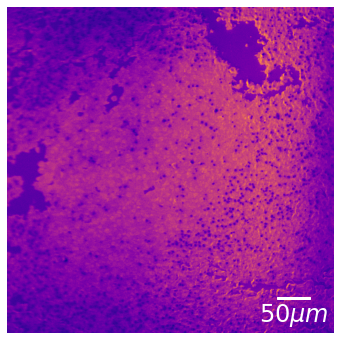

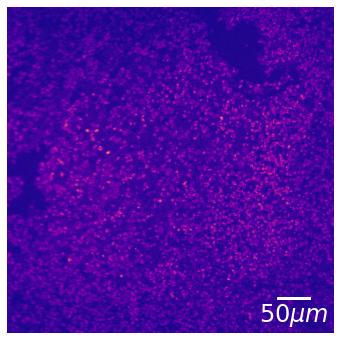

In [10]:
for dataset in datasets:
    # Read images and get PO3 channel
    print(dataset)
    imgs, labels, fov = get_imgs(experiment, dataset)
    img_total = get_imgs_index(imgs, [0,1])
    img_nuclei = get_imgs_index(imgs, [18, 32, 55])
    
    X, Y, Z = plot_2D(img_total, fov, scale=5, path=images_dir / f'{experiment}_{dataset}_total_2D.png')
    plot_3D(X, Y, Z, fov, path=images_dir / f'{experiment}_{dataset}_total_3D.png')

    X, Y, Z = plot_2D(img_nuclei, fov, scale=2.5, path=images_dir / f'{experiment}_{dataset}_nuclei_2D.png')
    plot_3D(X, Y, Z, fov, path=images_dir / f'{experiment}_{dataset}_nuclei_3D.png')
    
    break